In [1]:
# For passwords & database access:
import psycopg2
import psycopg2.extras
import getpass

# For plotting
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display
import ipywidgets

# For math
import numpy as np
import pandas as pd
from decam_utils import *

import time

This notebook searches the extragalactic fields for candidates that (on their first night of detection) rose by at least 0.2 mag over at least 4 detections

In [2]:
# Logging in
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")
db = psycopg2.connect( f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'" )

db.autocommit = True # Makes the computer nicer about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

DB User:  kennedyt
DB Password:  ············


#### The filter parameters

In [3]:
errmult = .25 # the fraction of an error bar we want to give as leeway (1 is a full error bar, 0 is zero tolerance).

numdet = 5 # Minimum number of detections on the first night of data for the filter to consider a candidate

magamp = 0.2 # Minimum magnitude change throughout the candidates first night of detection

#### The filter

In [4]:
# Get a list of every MJD for which we have an image
query = ("SELECT e.mjd FROM exposures e "
         "WHERE e.proposalid = '2021A-0113' "
         "OR e.proposalid = '2021B-0149' "
         "LIMIT 10000000")
cursor.execute( query, )

datesquery = np.array(cursor.fetchall())

In [5]:
# Make a list of every observing night (by rounding to the nearest MJD)
odates = np.unique( np.round( datesquery ) )

In [31]:
fr = []
frdates = []
filidx = []

t1 = time.time() # should be about 30 seconds

goodfnms = good_fnms(cursor)[0]

for field in ["COSMOS", "ELIAS"]:
    for fil in ["g","r","i"]:
        tempfr = [] # List for the names of fast-rising candidates
        tempfrdates = [] # List for the dates on which fast riser behavior was observed
        
        oldcands = np.array( [] ) # used to check if candidates have been detected before

        for i in range(len(odates)):
            # Loop through each observing night
            # Grab all detections within a day of the night in question
            lodate = odates[i] - 1
            hidate = odates[i] + 1
            if field == "COSMOS":
                query = ("SELECT o.candidate_id, o.id, e.mjd, o.mag, rbs.rb, e.id, o.magerr FROM objects o "
                         "JOIN subtractions s ON s.id=o.subtraction_id "
                         "JOIN exposures e on s.exposure_id = e.id "
                         "JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 "
                         "WHERE q3c_radial_query(e.ra,e.dec,150,2.2,3) "
                         "AND rbs.rb > 0.4 "
                         "AND e.mjd > %s "
                         "AND e.mjd < %s "
                         "AND e.filter = %s "
                         "AND (e.proposalid = '2021A-0113' "
                         "OR e.proposalid = '2021B-0149') "
                         "LIMIT 10000000")
            elif field == "ELIAS":
                query = ("SELECT o.candidate_id, o.id, e.mjd, o.mag, rbs.rb, e.id, o.magerr FROM objects o "
                         "JOIN subtractions s ON s.id=o.subtraction_id "
                         "JOIN exposures e on s.exposure_id = e.id "
                         "JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 "
                         "WHERE q3c_radial_query(o.ra,o.dec,8.5,-43.5,2) "
                         "AND rbs.rb > 0.4 "
                         "AND e.mjd > %s "
                         "AND e.mjd < %s "
                         "AND e.filter = %s "
                         "AND (e.proposalid = '2021A-0113' "
                         "OR e.proposalid = '2021B-0149') "
                         "LIMIT 10000000")
            cursor.execute( query, ( lodate, hidate, fil, ) )

            # Store that nights detections in an array
            tempres = np.array( cursor.fetchall(), dtype=str ).transpose()

            if len( tempres ) > 0: # Takes care of errors from gaps in the observations by skipping empty nights
                # print(field, fil, i)
                # Cut out duplicate objects
                dupearr = np.array( [tempres[0], tempres[2], tempres[3], tempres[4], tempres[5], tempres[6]] ).transpose()
                dupearr = [ " ".join(j) for j in dupearr ]
                dupearr, ind = np.unique( dupearr, return_index=True )

                # Rejoin the array without the duplicates
                uarr = np.array( [ i.split(" ") for i in dupearr ] ).transpose()
                res = np.array( [uarr[0], tempres[1][ind], uarr[1], uarr[2], uarr[3], uarr[4], uarr[5]] )
                
                len1 = len(res[0])
                # Cut out non-science images
                # msk = np.isin(res[5], goodfnms)
                # res = np.array([i[msk] for i in res])
                # len2 = len(res[0])
                # if len1 != len2:
                #     print(field, fil, i)
                
                # Create an array of each unique candidate detected that night
                ucands, uind, ucounts = np.unique( res[0], return_counts=True, return_index=True )
                
                # Isolate those with at least numdet detections
                goodcands = ucands[ ucounts >= numdet ]


                # Make an array of detections for each of those candidates, store all of those arrays in "arr"
                arr = np.ones( len( goodcands ), dtype=object )
                for j in range( len( goodcands ) ):
                    arr[j] = res[:,res[0,:] == goodcands[j]]
                # Mask out those that 
                # A) have been detected in previous nights,
                # B) don"t rise in every subsequent detection, or 
                # C) don"t change by at least 0.2 mag
                good = np.ones( len( arr ), dtype=bool )
                for j in range( len( arr ) ):
                    # A)
                    # if arr[j][0][0] in oldcands:
                    #     good[j] = False
                    for k in range( len( arr[j][3] ) - 1 ):
                        # B)
                        if float(arr[j][3][k]) + errmult * float(arr[j][6][k]) < float(arr[j][3][k + 1]) - errmult * float(arr[j][6][k+1]):
                            good[j] = False
                        # C)
                        amp = np.max( arr[j][3].astype(float) ) - np.min( arr[j][3].astype(float) )
                        if amp < magamp:
                            good[j] = False
                    
                # Apply those cuts and append the candidates that passed to fr and frdates
                for j in range( len( arr[good] ) ):
                    tempfr.append( arr[good][j][0][0] )
                    tempfrdates.append( [lodate, hidate] )
            
            # Make a note of all candidates detected this night (for cutting out things that have been previously detected)
            try:
                oldcands = np.append( oldcands, ucands )
            except NameError:
                pass
            fr.append(tempfr)
            frdates.append(tempfrdates)
        filidx.append([len(j) for j in fr][-1])
        
x = []
y = []
ind = np.unique(fr, return_index=True)[1]
for i in [fr[ind] for ind in sorted(ind)]:
    x.extend(i)
for i in [frdates[ind] for ind in sorted(ind)]:
    y.extend(i)
fr = x
frdates = y

t2 = time.time()
print(t2-t1)

del x, y, ind

30.429207801818848


/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [22]:
filidx

[17, 22, 11, 10, 7, 6]

In [17]:
filidx

array([17, 22, 11, 10,  7,  6])

In [24]:
len(fr)

73

#### Record the change in amplitude over the night when the filter was pinged

In [32]:
amps = np.ones( len( fr ), dtype=object )

for i in range( len( fr ) ):
    amps[i] = []
    for fil in ["g","r","i"]:
        query = ("SELECT o.mag, e.mjd FROM objects o "
                 "JOIN subtractions s ON s.id=o.subtraction_id "
                 "JOIN exposures e on s.exposure_id = e.id "
                 "JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 "
                 "WHERE rbs.rb > 0.4 "
                 "AND e.mjd > %s "
                 "AND e.mjd < %s "
                 "AND e.filter = %s "
                 "AND (e.proposalid = '2021A-0113' "
                 "OR e.proposalid = '2021B-0149') "
                 "AND o.candidate_id = %s "
                 "ORDER BY e.mjd "
                 "LIMIT 10000000")

        cursor.execute( query, ( frdates[i][0], frdates[i][1], fil, fr[i], ) )
        tempres = np.array( cursor.fetchall(), dtype=float ).transpose()
        # print(tempres[0])
        if len(tempres) == 0:
            amps[i].append(0)
        elif len(tempres[0]) < numdet:
            amps[i].append(0)
        elif np.max(tempres[0]) - np.min(tempres[0]) < magamp:
            amps[i].append(0)
        else:
            amps[i].append(np.max(tempres[0]) - np.min(tempres[0]))
amps = [i for i in amps]

#### Record the max magnitude overall in the bandpass and determine if the filter was passed on a candidates first or only night

In [33]:
maxmag = np.ones( len( fr ), dtype=object )
fn = np.ones( len( fr ), dtype=object )
on = np.ones( len( fr ), dtype=object )
for i in range(len(fr)):
    maxmag[i] = []
    fn[i] = []
    on[i] = []
    for fil in ["g","r","i"]:
        query = ("SELECT o.mag, e.mjd FROM objects o "
                 "JOIN subtractions s ON s.id=o.subtraction_id "
                 "JOIN exposures e on s.exposure_id = e.id "
                 "JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 "
                 "WHERE rbs.rb > 0.4 "
                 "AND e.filter = %s "
                 "AND (e.proposalid = '2021A-0113' "
                 "OR e.proposalid = '2021B-0149') "
                 "AND o.candidate_id = %s "
                 "ORDER BY e.mjd "
                 "LIMIT 10000000")
        cursor.execute( query, ( fil, fr[i], ) )
        tempres = np.array( cursor.fetchall(), dtype=float ).transpose()
        if len(tempres) == 0:
            maxmag[i].append(0)
            fn[i].append(False)
            on[i].append(False)
        else:
            maxmag[i].append(np.min(tempres[0]))
            lastnight = float(tempres[1][-1])
            firstnight = float(tempres[1][0])
            if firstnight < frdates[i][0]:
                fn[i].append(False)
                on[i].append(False)
            else:
                fn[i].append(True)
                if lastnight > frdates[i][1]:
                    on[i].append(False)
                else:
                    on[i].append(True)


#### Combine all that info into a DataFrame

In [34]:
df = pd.DataFrame(index = range(len(fr)), columns = ["CandID", "Field", "Filter", "Night", "DelMag", "PeakMag", "FirstNight", "OnlyNight"])
for i in range(len(fr)):
    df["CandID"][i] = fr[i]
    if i < sum(filidx[:3]):
        df["Field"][i] = "COSMOS"
    else: 
        df["Field"][i] = "ELAIS"
    df["Night"][i] = frdates[i][0]+1
    if i < filidx[0]:
        df["Filter"][i] = "g"
        df["DelMag"][i] = amps[i][0]
        df["PeakMag"][i] = maxmag[i][0]
        df["FirstNight"][i] = fn[i][0]
        df["OnlyNight"][i] = on[i][0]
    elif (i >= filidx[0]) & (i < sum(filidx[:2])):
        df["Filter"][i] = "r"
        df["DelMag"][i] = amps[i][1]
        df["PeakMag"][i] = maxmag[i][1]
        df["FirstNight"][i] = fn[i][1]
        df["OnlyNight"][i] = on[i][1]
    elif (i >= sum(filidx[:2])) & (i < sum(filidx[:3])):
        df["Filter"][i] = "i"
        df["DelMag"][i] = amps[i][2]
        df["PeakMag"][i] = maxmag[i][2]
        df["FirstNight"][i] = fn[i][2]
        df["OnlyNight"][i] = on[i][2]
    elif (i >= sum(filidx[:3])) & (i < sum(filidx[:4])):
        df["Filter"][i] = "g"
        df["DelMag"][i] = amps[i][0]
        df["PeakMag"][i] = maxmag[i][0]
        df["FirstNight"][i] = fn[i][0]
        df["OnlyNight"][i] = on[i][0]
    elif (i >= sum(filidx[:4])) & (i < sum(filidx[:5])):
        df["Filter"][i] = "r"
        df["DelMag"][i] = amps[i][1]
        df["PeakMag"][i] = maxmag[i][1]
        df["FirstNight"][i] = fn[i][1]
        df["OnlyNight"][i] = on[i][1]
    elif (i >= sum(filidx[:5])): #& (i < sum(filidx[:6])):
        df["Filter"][i] = "i"
        df["DelMag"][i] = amps[i][2]
        df["PeakMag"][i] = maxmag[i][2]
        df["FirstNight"][i] = fn[i][2]
        df["OnlyNight"][i] = on[i][2]
        
### This takes care of duplicates that arise from having observations closer together than usual
df = df.drop_duplicates(subset=["CandID", "Field", "Filter", "DelMag", "PeakMag"])
try:
    df = df.reset_index(drop=True)
except ValueError:
    pass
fr = df["CandID"]
frdates = [[df["Night"][i]-1,df["Night"][i]+1] for i in range(len(fr))]

In [35]:
### Summary of Results:
print("There were %s total fast risers" % len(df))
print("%s in g, %s in r, and %s in i" % (len(df[df["Filter"]=="g"]), len(df[df["Filter"]=="r"]), len(df[df["Filter"]=="i"])))
print("%s in COSMOS, %s in ELAIS" % (len(df[df["Field"]=="COSMOS"]), len(df[df["Field"]=="ELAIS"])))
print("%s of these rose quickly on their first night" % len(df[df["FirstNight"]==True]))
print("%s of those were only detected on one night" % len(df[df["OnlyNight"]==True]))

There were 69 total fast risers
25 in g, 28 in r, and 16 in i
50 in COSMOS, 19 in ELAIS
4 of these rose quickly on their first night
0 of those were only detected on one night


#### How much did the fast risers rise in a night?

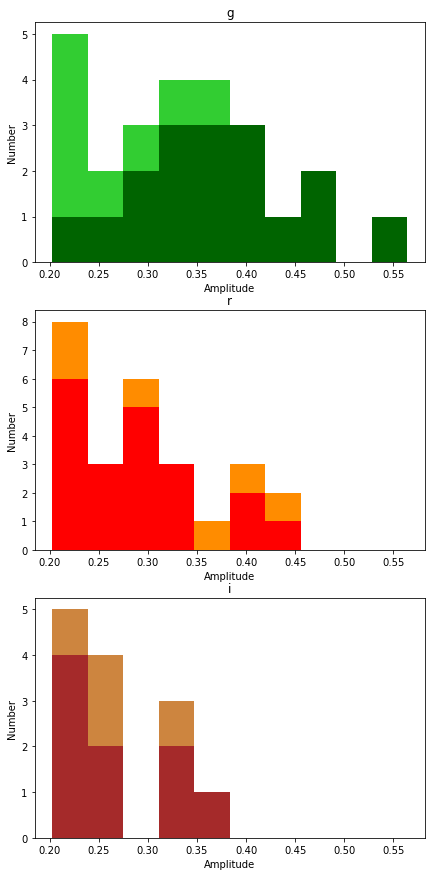

In [36]:
fig, ax = plt.subplots(3, sharex=True, figsize=[7,15])
bins = ax[0].hist(
    [df["DelMag"].where((df["Filter"]=="g") & (df["Field"]=="COSMOS")).dropna(),
    df["DelMag"].where((df["Filter"]=="g") & (df["Field"]=="ELAIS")).dropna()],
    color=["darkgreen","limegreen"], 
    stacked=True)[1]
ax[0].set_xlabel("Amplitude")
ax[0].set_ylabel("Number")
ax[0].set_title("g")
ax[0].tick_params(labelbottom=True)

ax[1].hist(
    [df["DelMag"].where((df["Filter"]=="r") & (df["Field"]=="COSMOS")).dropna(),
    df["DelMag"].where((df["Filter"]=="r") & (df["Field"]=="ELAIS")).dropna()],
    color=["red","darkorange"],
    bins=bins,
    stacked=True)
ax[1].set_xlabel("Amplitude")
ax[1].set_ylabel("Number")
ax[1].set_title("r")
ax[1].tick_params(labelbottom=True)

ax[2].hist(
    [df["DelMag"].where((df["Filter"]=="i") & (df["Field"]=="COSMOS")).dropna(),
    df["DelMag"].where((df["Filter"]=="i") & (df["Field"]=="ELAIS")).dropna()],
    color=["brown","peru"],
    bins=bins,
    stacked=True)
ax[2].set_xlabel("Amplitude")
ax[2].set_ylabel("Number")
ax[2].set_title("i");

#### Plotting lightcurves/cutouts next to dataframe printout

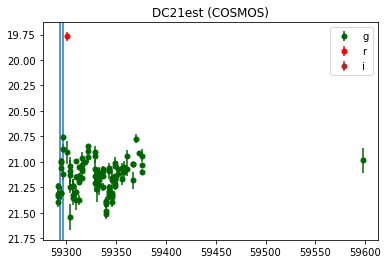

CandID          DC21est
Field            COSMOS
Filter                g
Night           59295.0
DelMag         0.315473
PeakMag       20.757774
FirstNight        False
OnlyNight         False
Name: 0, dtype: object


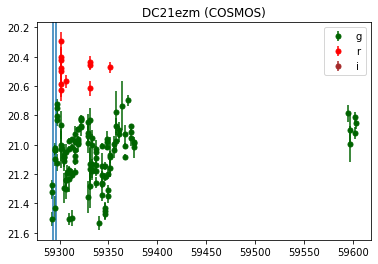

CandID          DC21ezm
Field            COSMOS
Filter                g
Night           59295.0
DelMag         0.406396
PeakMag       20.698603
FirstNight        False
OnlyNight         False
Name: 1, dtype: object


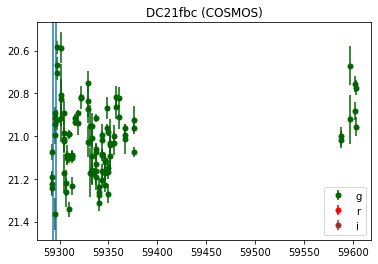

CandID          DC21fbc
Field            COSMOS
Filter                g
Night           59295.0
DelMag         0.471668
PeakMag       20.584149
FirstNight        False
OnlyNight         False
Name: 2, dtype: object


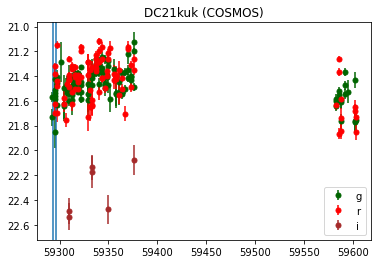

CandID          DC21kuk
Field            COSMOS
Filter                g
Night           59295.0
DelMag         0.428156
PeakMag       21.122954
FirstNight        False
OnlyNight         False
Name: 3, dtype: object


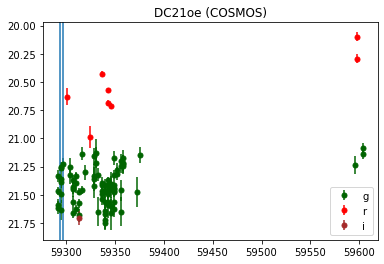

CandID           DC21oe
Field            COSMOS
Filter                g
Night           59295.0
DelMag          0.38513
PeakMag       21.086223
FirstNight        False
OnlyNight         False
Name: 4, dtype: object


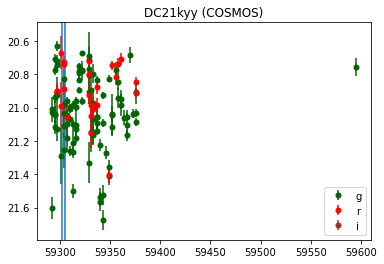

CandID         DC21kyy
Field           COSMOS
Filter               g
Night          59304.0
DelMag        0.429508
PeakMag       20.63102
FirstNight       False
OnlyNight        False
Name: 5, dtype: object


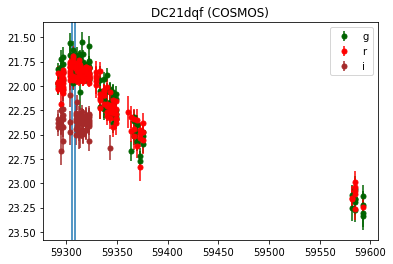

CandID          DC21dqf
Field            COSMOS
Filter                g
Night           59307.0
DelMag          0.34103
PeakMag       21.549755
FirstNight        False
OnlyNight         False
Name: 6, dtype: object


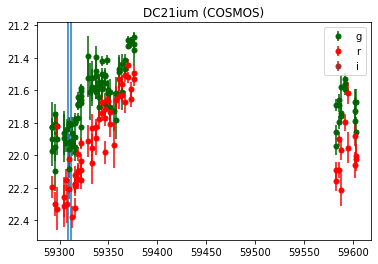

CandID          DC21ium
Field            COSMOS
Filter                g
Night           59310.0
DelMag         0.280798
PeakMag       21.270059
FirstNight        False
OnlyNight         False
Name: 7, dtype: object


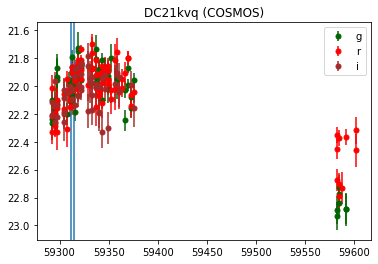

CandID          DC21kvq
Field            COSMOS
Filter                g
Night           59313.0
DelMag         0.307763
PeakMag       21.726192
FirstNight        False
OnlyNight         False
Name: 8, dtype: object


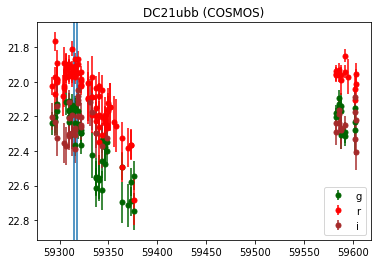

CandID          DC21ubb
Field            COSMOS
Filter                g
Night           59316.0
DelMag         0.228007
PeakMag       22.094534
FirstNight        False
OnlyNight         False
Name: 9, dtype: object


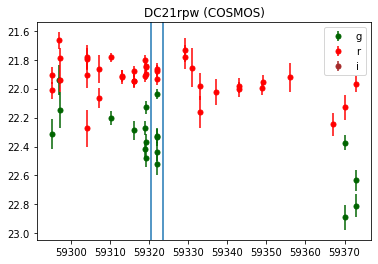

CandID          DC21rpw
Field            COSMOS
Filter                g
Night           59322.0
DelMag         0.482404
PeakMag       21.942686
FirstNight        False
OnlyNight         False
Name: 10, dtype: object


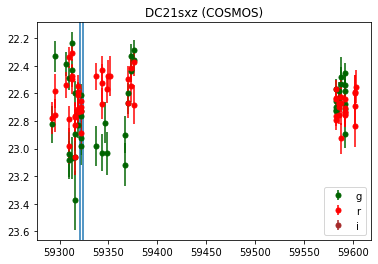

CandID          DC21sxz
Field            COSMOS
Filter                g
Night           59322.0
DelMag         0.374217
PeakMag       22.233238
FirstNight        False
OnlyNight         False
Name: 11, dtype: object


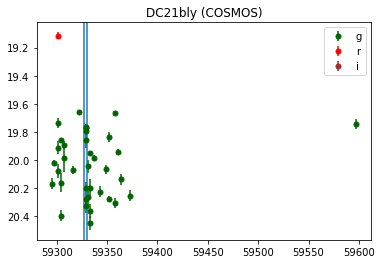

CandID          DC21bly
Field            COSMOS
Filter                g
Night           59329.0
DelMag         0.564434
PeakMag       19.657813
FirstNight        False
OnlyNight         False
Name: 12, dtype: object


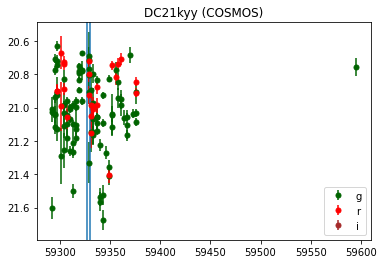

CandID         DC21kyy
Field           COSMOS
Filter               g
Night          59329.0
DelMag        0.640807
PeakMag       20.63102
FirstNight       False
OnlyNight        False
Name: 13, dtype: object


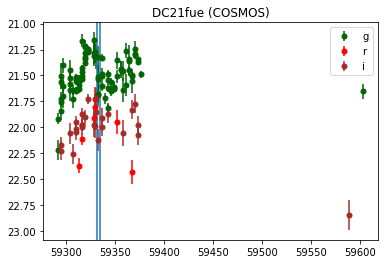

CandID          DC21fue
Field            COSMOS
Filter                g
Night           59333.0
DelMag         0.366257
PeakMag       21.155485
FirstNight        False
OnlyNight         False
Name: 14, dtype: object


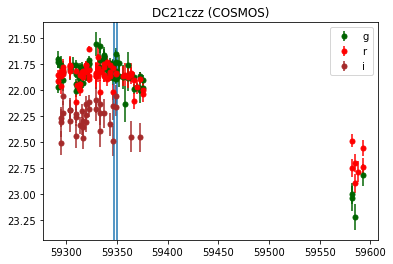

CandID          DC21czz
Field            COSMOS
Filter                g
Night           59349.0
DelMag         0.239836
PeakMag       21.558074
FirstNight        False
OnlyNight         False
Name: 15, dtype: object


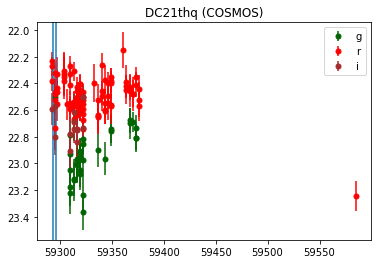

CandID         DC21thq
Field           COSMOS
Filter               r
Night          59295.0
DelMag        0.410499
PeakMag       22.15047
FirstNight       False
OnlyNight        False
Name: 16, dtype: object


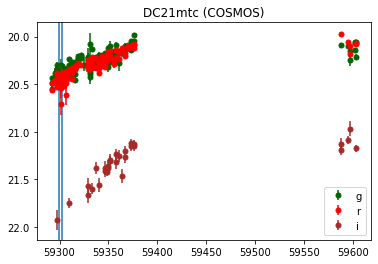

CandID          DC21mtc
Field            COSMOS
Filter                r
Night           59301.0
DelMag         0.304642
PeakMag       19.973298
FirstNight        False
OnlyNight         False
Name: 17, dtype: object


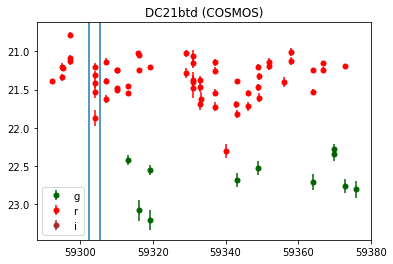

CandID          DC21btd
Field            COSMOS
Filter                r
Night           59304.0
DelMag         0.670868
PeakMag       20.779586
FirstNight        False
OnlyNight         False
Name: 18, dtype: object


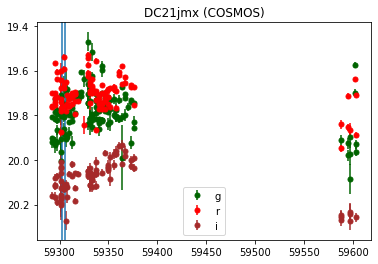

CandID          DC21jmx
Field            COSMOS
Filter                r
Night           59304.0
DelMag         0.219331
PeakMag       19.530465
FirstNight        False
OnlyNight         False
Name: 19, dtype: object


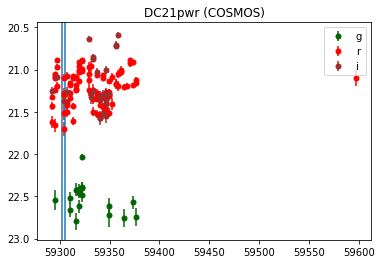

CandID          DC21pwr
Field            COSMOS
Filter                r
Night           59304.0
DelMag         0.605386
PeakMag       20.890568
FirstNight        False
OnlyNight         False
Name: 20, dtype: object


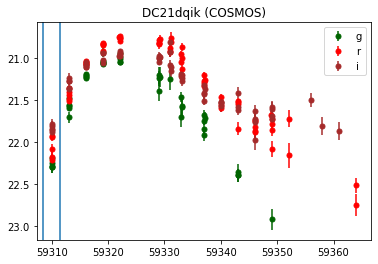

CandID         DC21dqik
Field            COSMOS
Filter                r
Night           59310.0
DelMag         0.281211
PeakMag       20.736868
FirstNight         True
OnlyNight         False
Name: 21, dtype: object


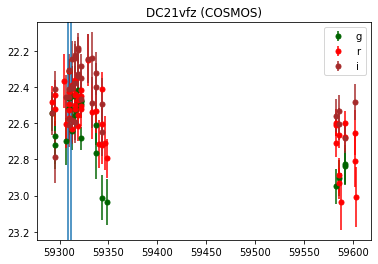

CandID          DC21vfz
Field            COSMOS
Filter                r
Night           59310.0
DelMag          0.26259
PeakMag       22.250965
FirstNight        False
OnlyNight         False
Name: 22, dtype: object


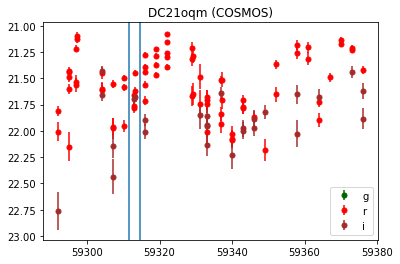

CandID          DC21oqm
Field            COSMOS
Filter                r
Night           59313.0
DelMag         0.329367
PeakMag       21.079405
FirstNight        False
OnlyNight         False
Name: 23, dtype: object


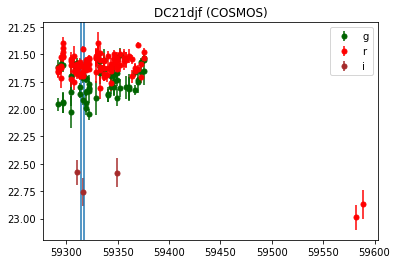

CandID          DC21djf
Field            COSMOS
Filter                r
Night           59316.0
DelMag         0.247023
PeakMag       21.396153
FirstNight        False
OnlyNight         False
Name: 24, dtype: object


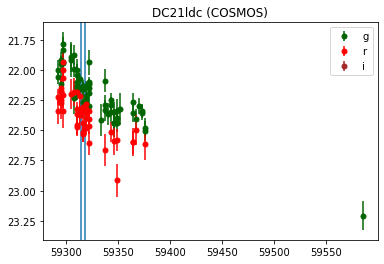

CandID          DC21ldc
Field            COSMOS
Filter                r
Night           59316.0
DelMag           0.2184
PeakMag       21.932041
FirstNight        False
OnlyNight         False
Name: 25, dtype: object


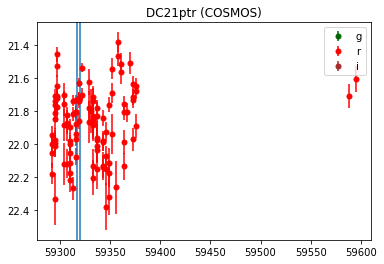

CandID          DC21ptr
Field            COSMOS
Filter                r
Night           59319.0
DelMag         0.233406
PeakMag       21.379395
FirstNight        False
OnlyNight         False
Name: 26, dtype: object


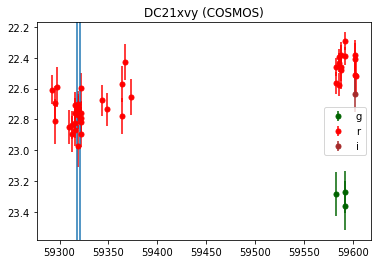

CandID          DC21xvy
Field            COSMOS
Filter                r
Night           59319.0
DelMag         0.275685
PeakMag       22.292236
FirstNight        False
OnlyNight         False
Name: 27, dtype: object


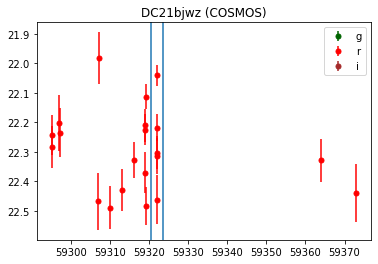

CandID         DC21bjwz
Field            COSMOS
Filter                r
Night           59322.0
DelMag         0.421386
PeakMag       21.982246
FirstNight        False
OnlyNight         False
Name: 28, dtype: object


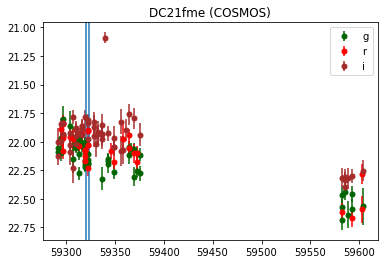

CandID          DC21fme
Field            COSMOS
Filter                r
Night           59322.0
DelMag         0.334757
PeakMag       21.837038
FirstNight        False
OnlyNight         False
Name: 29, dtype: object


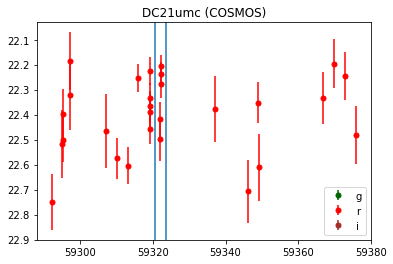

CandID          DC21umc
Field            COSMOS
Filter                r
Night           59322.0
DelMag         0.293386
PeakMag       22.185129
FirstNight        False
OnlyNight         False
Name: 30, dtype: object


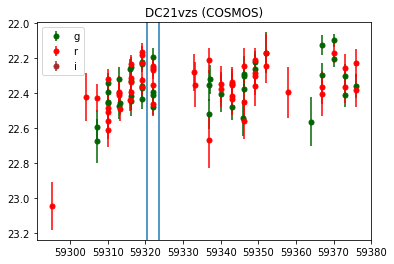

CandID         DC21vzs
Field           COSMOS
Filter               r
Night          59322.0
DelMag        0.214025
PeakMag       22.16698
FirstNight       False
OnlyNight        False
Name: 31, dtype: object


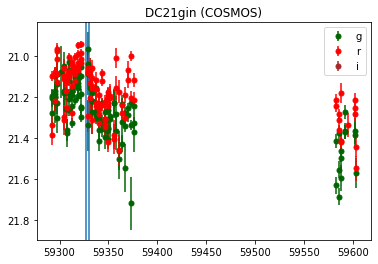

CandID          DC21gin
Field            COSMOS
Filter                r
Night           59329.0
DelMag           0.2365
PeakMag       20.942078
FirstNight        False
OnlyNight         False
Name: 32, dtype: object


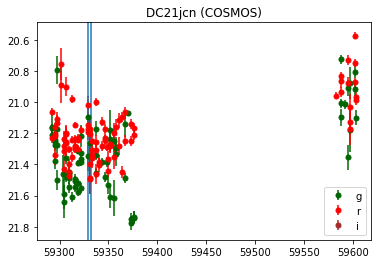

CandID          DC21jcn
Field            COSMOS
Filter                r
Night           59331.0
DelMag         0.317802
PeakMag       20.572338
FirstNight        False
OnlyNight         False
Name: 33, dtype: object


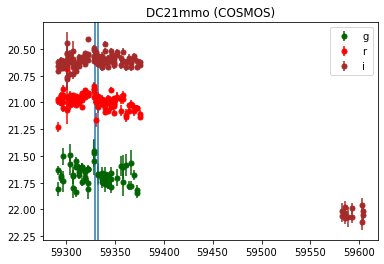

CandID          DC21mmo
Field            COSMOS
Filter                r
Night           59331.0
DelMag         0.208501
PeakMag       20.691184
FirstNight        False
OnlyNight         False
Name: 34, dtype: object


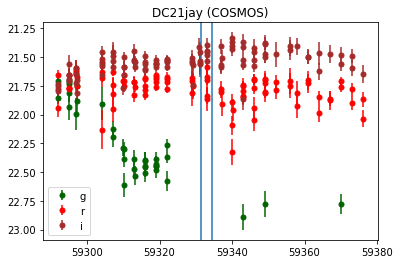

CandID          DC21jay
Field            COSMOS
Filter                r
Night           59333.0
DelMag         0.284022
PeakMag       21.540902
FirstNight        False
OnlyNight         False
Name: 35, dtype: object


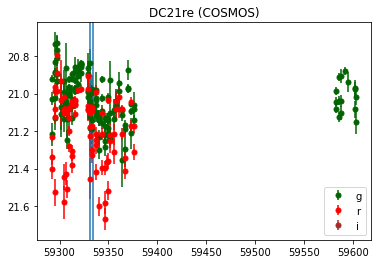

CandID           DC21re
Field            COSMOS
Filter                r
Night           59333.0
DelMag         0.255917
PeakMag       20.796101
FirstNight        False
OnlyNight         False
Name: 36, dtype: object


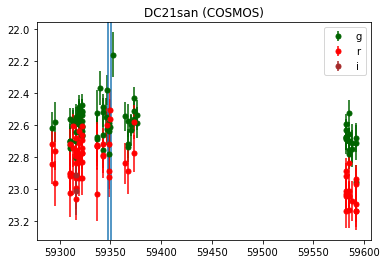

CandID          DC21san
Field            COSMOS
Filter                r
Night           59349.0
DelMag         0.414456
PeakMag       22.507728
FirstNight        False
OnlyNight         False
Name: 37, dtype: object


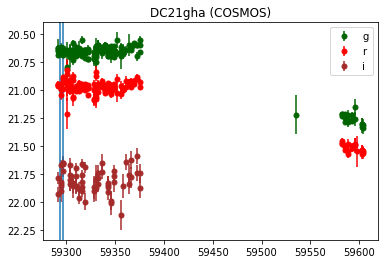

CandID         DC21gha
Field           COSMOS
Filter               i
Night          59295.0
DelMag         0.22949
PeakMag       21.59017
FirstNight       False
OnlyNight        False
Name: 38, dtype: object


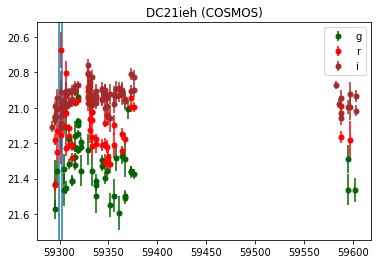

CandID          DC21ieh
Field            COSMOS
Filter                i
Night           59301.0
DelMag         0.201129
PeakMag       20.756587
FirstNight        False
OnlyNight         False
Name: 39, dtype: object


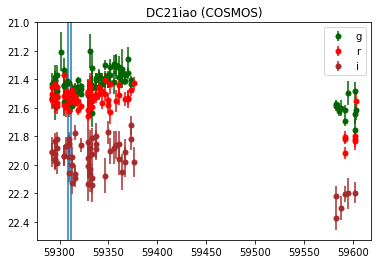

CandID          DC21iao
Field            COSMOS
Filter                i
Night           59310.0
DelMag         0.232652
PeakMag       21.721893
FirstNight        False
OnlyNight         False
Name: 40, dtype: object


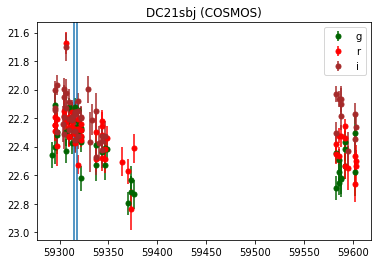

CandID          DC21sbj
Field            COSMOS
Filter                i
Night           59316.0
DelMag         0.201691
PeakMag       21.700997
FirstNight        False
OnlyNight         False
Name: 41, dtype: object


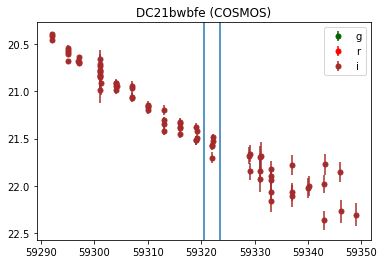

CandID        DC21bwbfe
Field            COSMOS
Filter                i
Night           59322.0
DelMag         0.214059
PeakMag       20.397707
FirstNight        False
OnlyNight         False
Name: 42, dtype: object


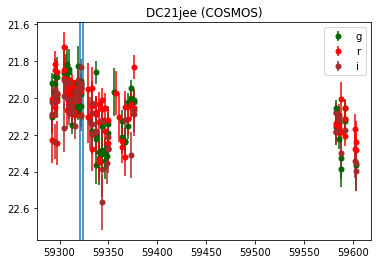

CandID         DC21jee
Field           COSMOS
Filter               i
Night          59322.0
DelMag        0.268987
PeakMag       21.83062
FirstNight       False
OnlyNight        False
Name: 43, dtype: object


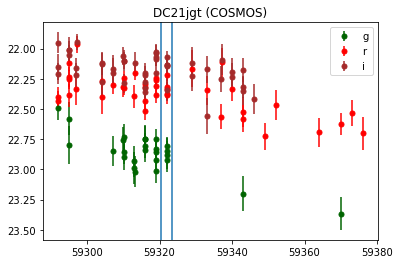

CandID          DC21jgt
Field            COSMOS
Filter                i
Night           59322.0
DelMag         0.266921
PeakMag       21.943507
FirstNight        False
OnlyNight         False
Name: 44, dtype: object


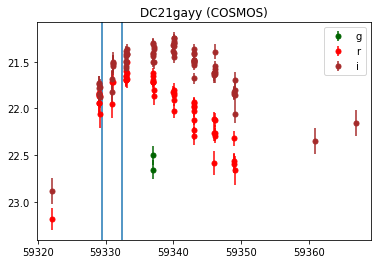

CandID         DC21gayy
Field            COSMOS
Filter                i
Night           59331.0
DelMag         0.316381
PeakMag       21.240056
FirstNight        False
OnlyNight         False
Name: 45, dtype: object


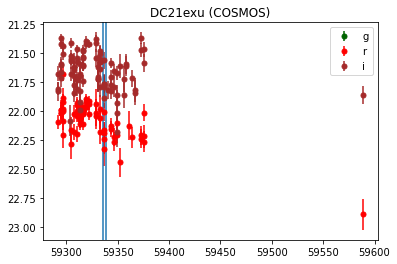

CandID          DC21exu
Field            COSMOS
Filter                i
Night           59337.0
DelMag         0.323795
PeakMag       21.371223
FirstNight        False
OnlyNight         False
Name: 46, dtype: object


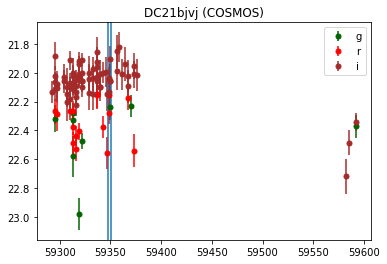

CandID         DC21bjvj
Field            COSMOS
Filter                i
Night           59349.0
DelMag         0.229273
PeakMag       21.820999
FirstNight        False
OnlyNight         False
Name: 47, dtype: object


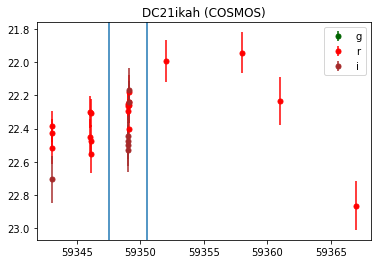

CandID         DC21ikah
Field            COSMOS
Filter                i
Night           59349.0
DelMag         0.357201
PeakMag       22.170156
FirstNight        False
OnlyNight         False
Name: 48, dtype: object


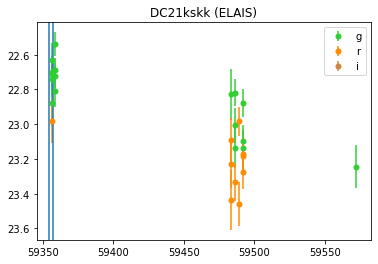

CandID        DC21kskk
Field            ELAIS
Filter               g
Night          59356.0
DelMag        0.248839
PeakMag       22.53787
FirstNight        True
OnlyNight        False
Name: 49, dtype: object


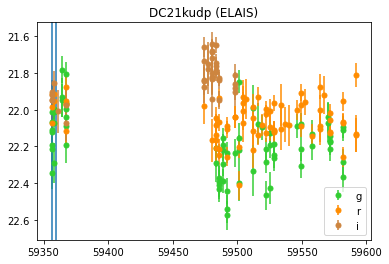

CandID         DC21kudp
Field             ELAIS
Filter                g
Night           59358.0
DelMag         0.293915
PeakMag       21.782062
FirstNight        False
OnlyNight         False
Name: 50, dtype: object


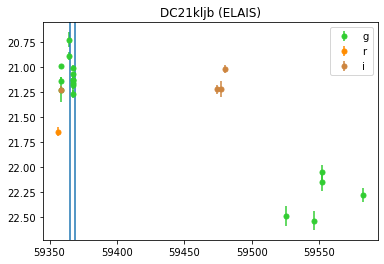

CandID         DC21kljb
Field             ELAIS
Filter                g
Night           59367.0
DelMag         0.261342
PeakMag       20.727999
FirstNight        False
OnlyNight         False
Name: 51, dtype: object


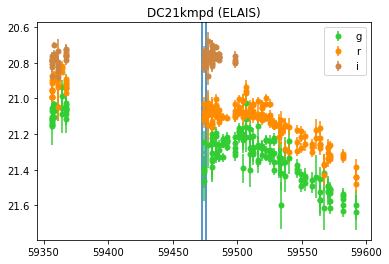

CandID         DC21kmpd
Field             ELAIS
Filter                g
Night           59474.0
DelMag         0.215302
PeakMag       20.937068
FirstNight        False
OnlyNight         False
Name: 52, dtype: object


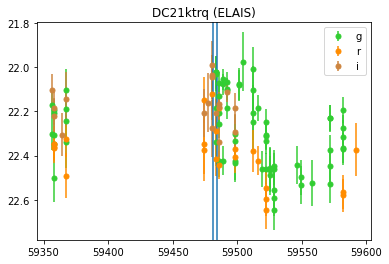

CandID         DC21ktrq
Field             ELAIS
Filter                g
Night           59483.0
DelMag         0.317531
PeakMag       21.975308
FirstNight        False
OnlyNight         False
Name: 53, dtype: object


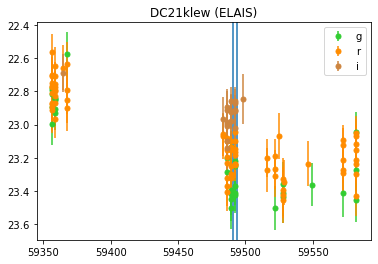

CandID         DC21klew
Field             ELAIS
Filter                g
Night           59492.0
DelMag         0.202552
PeakMag       22.578522
FirstNight        False
OnlyNight         False
Name: 54, dtype: object


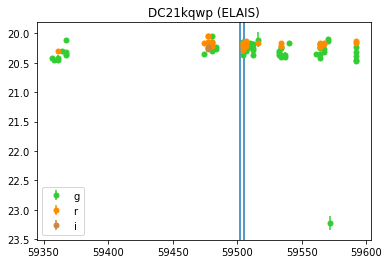

CandID         DC21kqwp
Field             ELAIS
Filter                g
Night           59504.0
DelMag         0.231861
PeakMag       20.042383
FirstNight        False
OnlyNight         False
Name: 55, dtype: object


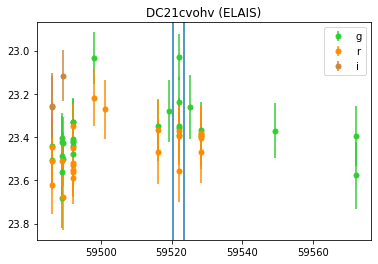

CandID        DC21cvohv
Field             ELAIS
Filter                g
Night           59522.0
DelMag         0.357597
PeakMag       23.030774
FirstNight        False
OnlyNight         False
Name: 56, dtype: object


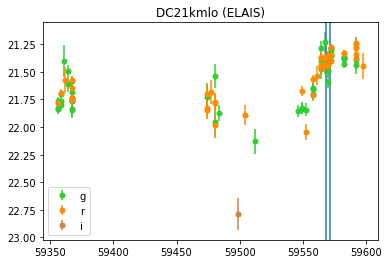

CandID         DC21kmlo
Field             ELAIS
Filter                g
Night           59570.0
DelMag         0.208808
PeakMag       21.229836
FirstNight        False
OnlyNight         False
Name: 57, dtype: object


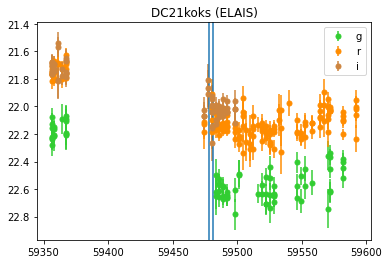

CandID         DC21koks
Field             ELAIS
Filter                r
Night           59480.0
DelMag         0.278081
PeakMag       21.626403
FirstNight        False
OnlyNight         False
Name: 58, dtype: object


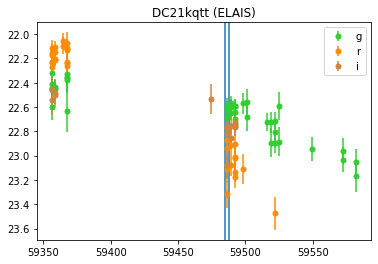

CandID         DC21kqtt
Field             ELAIS
Filter                r
Night           59486.0
DelMag         0.450783
PeakMag       22.059262
FirstNight        False
OnlyNight         False
Name: 59, dtype: object


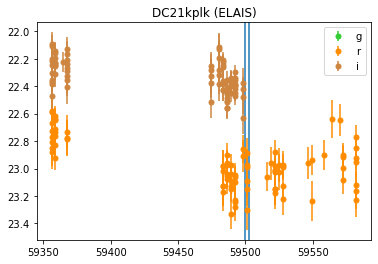

CandID         DC21kplk
Field             ELAIS
Filter                r
Night           59501.0
DelMag          0.41867
PeakMag       22.579958
FirstNight        False
OnlyNight         False
Name: 60, dtype: object


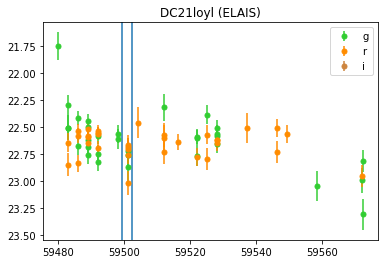

CandID         DC21loyl
Field             ELAIS
Filter                r
Night           59501.0
DelMag         0.351744
PeakMag       22.458455
FirstNight        False
OnlyNight         False
Name: 61, dtype: object


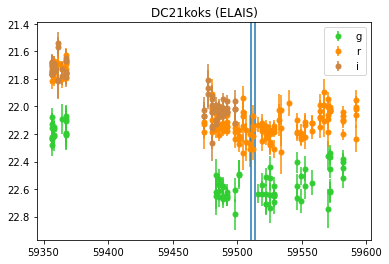

CandID         DC21koks
Field             ELAIS
Filter                r
Night           59512.0
DelMag         0.236449
PeakMag       21.626403
FirstNight        False
OnlyNight         False
Name: 62, dtype: object


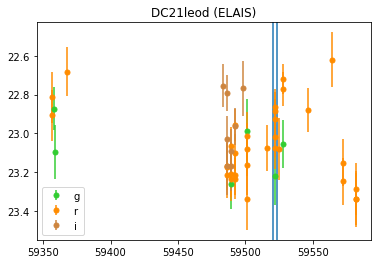

CandID         DC21leod
Field             ELAIS
Filter                r
Night           59522.0
DelMag         0.208724
PeakMag       22.619711
FirstNight        False
OnlyNight         False
Name: 63, dtype: object


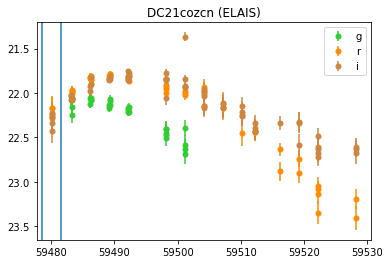

CandID        DC21cozcn
Field             ELAIS
Filter                i
Night           59480.0
DelMag          0.20227
PeakMag       21.365575
FirstNight         True
OnlyNight         False
Name: 64, dtype: object


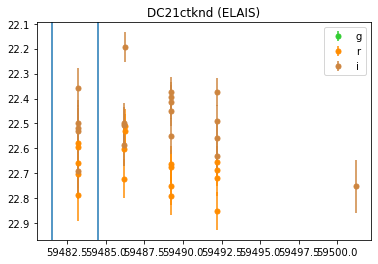

CandID        DC21ctknd
Field             ELAIS
Filter                i
Night           59483.0
DelMag         0.332324
PeakMag       22.193258
FirstNight         True
OnlyNight         False
Name: 65, dtype: object


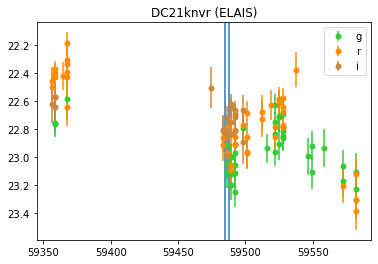

CandID         DC21knvr
Field             ELAIS
Filter                i
Night           59486.0
DelMag         0.266293
PeakMag       22.502735
FirstNight        False
OnlyNight         False
Name: 66, dtype: object


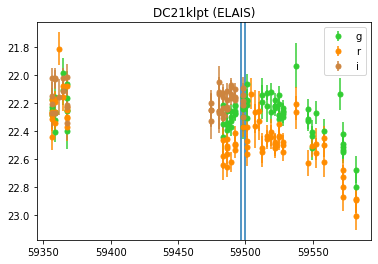

CandID         DC21klpt
Field             ELAIS
Filter                i
Night           59498.0
DelMag          0.20705
PeakMag       22.011772
FirstNight        False
OnlyNight         False
Name: 67, dtype: object


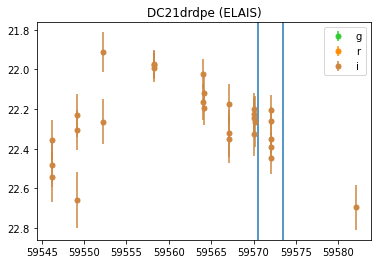

CandID        DC21drdpe
Field             ELAIS
Filter                i
Night           59572.0
DelMag         0.241447
PeakMag       21.911833
FirstNight        False
OnlyNight         False
Name: 68, dtype: object


In [30]:
### Plotting up each of the identified fast risers
### To plot some subset, replace the following line with "for i in df[CONDITION].index:", i.e. "for i in df[df["OnlyNight"]==True].index:"
### would plot only candidates that passed on their only detected night

for i in range( len( fr ) ):    
    ### Plotting the lightcurves
    query = ('SELECT c.id, e.mjd, o.mag, o.magerr, e.filter, o.ra FROM objects o '
             'JOIN candidates c ON c.id=o.candidate_id '
             'JOIN subtractions s ON s.id=o.subtraction_id '
             'JOIN exposures e ON e.id=s.exposure_id '
             'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
             'WHERE c.id=%s '
             'AND rbs.rb > 0.4')
    cursor.execute( query, ( fr[i], ) )
    
    array = np.array( cursor.fetchall() ).transpose()
    gmsk = array[4] == 'g'
    rmsk = array[4] == 'r'
    imsk = array[4] == 'i'
    
    
    # Color consistency
    if df["Field"][i] == "COSMOS": c = ["darkgreen","red","brown"]
    elif df["Field"][i] == "ELAIS": c = ["limegreen","darkorange","peru"]
    
    
    plt.errorbar( ( array[1][gmsk] ).astype(float), 
                 ( array[2][gmsk] ).astype(float), 
                 yerr=array[3][gmsk].astype(float), 
                 fmt='o', 
                 markersize=5, 
                 ls= '', 
                 color=c[0], 
                 label='g' )
    plt.errorbar( ( array[1][rmsk] ).astype(float), 
                 ( array[2][rmsk] ).astype(float), 
                 yerr=array[3][rmsk].astype(float), 
                 fmt='o', 
                 markersize=5, 
                 ls= '', 
                 color=c[1], 
                 label='r' )
    plt.errorbar( ( array[1][imsk] ).astype(float), 
                 ( array[2][imsk] ).astype(float), 
                 yerr=array[3][imsk].astype(float), 
                 fmt='o', 
                 markersize=5, 
                 ls= '', 
                 color=c[2], 
                 label='i' )
    
    ### Indicating the interesting part of the light curve
    plt.axvline( float( frdates[i][0] - 0.5 ) )
    plt.axvline( float( frdates[i][1] + 0.5 ) )
    
    plt.title( array[0][0]+" ("+df["Field"][i]+")")
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()
    
    ### Cutouts
    # query = ( 'SELECT cand.id, e.mjd,e.filename,e.filter,c.sci_jpeg,c.ref_jpeg,c.diff_jpeg FROM cutouts c '
    #           'INNER JOIN objects o ON c.object_id=o.id '
    #           'INNER JOIN candidates cand ON o.candidate_id=cand.id '
    #           'INNER JOIN subtractions s ON o.subtraction_id=s.id '
    #           'INNER JOIN exposures e ON s.exposure_id=e.id '
    #           'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
    #           'WHERE cand.id=%s '
    #           'AND rbs.rb > 0.4 '
    #           'ORDER BY e.mjd '
    #           'LIMIT 1')
    # cursor.execute( query, ( fr[i], ) )
    # for row in cursor:
    #     label = ipywidgets.HTML( f'<b>Candidate</b>{row["id"]}<br><b>{row["filename"]}</b><br><b>Filter:</b> {row["filter"]}' )
    #     newimg = ipywidgets.Image( value=bytes(row["sci_jpeg"]), width=102, height=102, format='jpeg' )
    #     refimg = ipywidgets.Image( value=bytes(row["ref_jpeg"]), width=102, height=102, format='jpeg' )
    #     subimg = ipywidgets.Image( value=bytes(row["diff_jpeg"]), width=102, height=102, format='jpeg' )
    #     box = ipywidgets.HBox( [ newimg, refimg, subimg, label ] )
    #     display( box )
    
    ### Details
    print(df.loc()[i])

In [14]:
# for i in fr:
#     query = ( 'SELECT cand.id, e.mjd,e.filename,e.filter,c.sci_jpeg,c.ref_jpeg,c.diff_jpeg FROM cutouts c '
#               'INNER JOIN objects o ON c.object_id=o.id '
#               'INNER JOIN candidates cand ON o.candidate_id=cand.id '
#               'INNER JOIN subtractions s ON o.subtraction_id=s.id '
#               'INNER JOIN exposures e ON s.exposure_id=e.id '
#               'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
#               'WHERE cand.id=%s '
#               'AND rbs.rb > 0.4 '
#               'ORDER BY e.mjd '
#               'LIMIT 3')
#     cursor.execute( query, ( i, ) )
#     for row in cursor:
#         label = ipywidgets.HTML( f'<b>Candidate</b>{row["id"]}<br><b>{row["filename"]}</b><br><b>Filter:</b> {row["filter"]}' )
#         newimg = ipywidgets.Image( value=bytes(row["sci_jpeg"]), width=102, height=102, format='jpeg' )
#         refimg = ipywidgets.Image( value=bytes(row["ref_jpeg"]), width=102, height=102, format='jpeg' )
#         subimg = ipywidgets.Image( value=bytes(row["diff_jpeg"]), width=102, height=102, format='jpeg' )
#         box = ipywidgets.HBox( [ newimg, refimg, subimg, label ] )
#         display( box )
#     print("")
#     print("")    
#     print("")    
#     print("")

In [ ]:
### Helpful little snippet to make searching candidates in SDSS/TNS searching a bit easier
# engine="TNS"
# engine="SDSS"

# coordarr = np.empty( len( fr ), dtype=object )
# for i in range(len(fr)):
#     query = ('SELECT c.id, c.ra, c.dec FROM candidates c '
#             'WHERE c.id=%s ')
#     cursor.execute( query, (fr[i], ) )
#     coordarr[i] = cursor.fetchall()[0]


# if engine == "SDSS":
#     for i in coordarr:
#         print(i[0])
#         print(str(i[1]))
#         print(str(i[2]))
# elif engine=="TNS":
#     for i in coordarr:
#         if i[2]>0:
#             print(i[0])
#             print(str(i[1]),"+"+str(i[2]))
#         else:
#             print(i[0])
#             print(str(i[1]),str(i[2]))

In [ ]:
# From SDSS matches (2021A):
# DC21fah-- STAR
# DC21mis-- STAR
# DC21nmo-- GALAXY
# DC21tbc-- GALAXY
# DC21crq-- STAR
# DC21flsx-- GALAXY
# ELIAS fast risers outside the SDSS footprint